In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from fe_gmx import AWH_Ensemble, AWH_2D_Ensemble

In [2]:
import dask
from dask.distributed import Client, LocalCluster
from ENPMDA import MDDataFrame
from ENPMDA.preprocessing import TrajectoryEnsemble

from scipy.spatial.distance import pdist, squareform

from sklearn.cluster import KMeans


In [3]:
from pomegranate.distributions import Normal
from pomegranate.gmm import GeneralMixtureModel

In [4]:
awh_ensemble = AWH_2D_Ensemble('../AWH_2D_PORE_LOOPC', regenerate_awh=True)

Found 185 awh_pmf files.
The latest awh_pmf file is ../AWH_2D_PORE_LOOPC/awh_result/awh_t368000.xvg
The latest awh_pmf file was generated at 2023-07-18 10:43:47
Found 8 walkers.
The latest walker was generated at 2023-07-17 10:44:20
Generating pulling data...
Generating log data...
Generating PMF data...


Generating PMF data: 100%|██████████| 185/185 [00:04<00:00, 38.28it/s]


In [5]:
awh_ensemble.awh_log[0]

AWH_LOG(filename=../AWH_2D_PORE_LOOPC/rep1/awh.log, index=0), covering_times=[35420, 60200, 122580, 148800], equlibrated_histogram_time=35420, out_of_initial_stage_time=148800

In [6]:
awh_pmf = awh_ensemble.awh_results.pmf[-1]

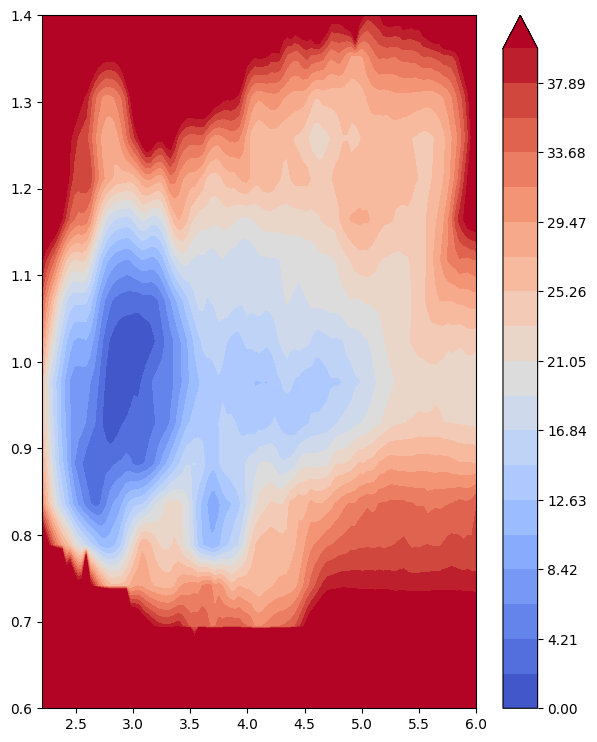

In [8]:
awh_cv1 = awh_pmf.T[0][0]
awh_cv2 = awh_pmf[0].T[1]
awh_fes = awh_pmf[:,:,2].T

fig, ax = plt.subplots(figsize=(7,9))

levels=np.linspace(0, 40, 20)
mappable = ax.contourf(
            awh_cv1,
            awh_cv2,
            awh_fes,
            vmax=40,
            levels=levels,
            extend='max',
            cmap='coolwarm')
plt.colorbar(mappable)

In [10]:
awh_ensemble.kT

2.494338785445972

In [9]:
awh_ensemble.generate_pmf_video(name='test',
                                levels=np.linspace(0, 40, 20),
                                stride=2)

  0%|          | 0/93 [00:00<?, ?it/s]

100%|██████████| 93/93 [00:15<00:00,  6.09it/s]


ffmpeg version N-96086-g3530fdc78e Copyright (c) 2000-2019 the FFmpeg developers
built with gcc 7 (Ubuntu 7.4.0-1ubuntu1~18.04.1)
configuration: --disable-x86asm
libavutil      56. 36.101 / 56. 36.101
libavcodec     58. 65.100 / 58. 65.100
libavformat    58. 35.101 / 58. 35.101
libavdevice    58.  9.101 / 58.  9.101
libavfilter     7. 69.101 /  7. 69.101
libswscale      5.  6.100 /  5.  6.100
libswresample   3.  6.100 /  3.  6.100
Input #0, image2, from 'test_%d.png':
Duration: 00:00:09.30, start: 0.000000, bitrate: N/A
Stream #0:0: Video: png, rgba(pc), 700x900 [SAR 3937:3937 DAR 7:9], 10 fps, 10 tbr, 10 tbn, 10 tbc
Please use -b:a or -b:v, -b is ambiguous
Stream mapping:
Stream #0:0 -> #0:0 (png (native) -> mpeg4 (native))
Press [q] to stop, [?] for help
Output #0, mp4, to 'test.mp4':
Metadata:
encoder         : Lavf58.35.101
Stream #0:0: Video: mpeg4 (mp4v / 0x7634706D), yuv420p, 700x900 [SAR 1:1 DAR 7:9], q=2-31, 5000 kb/s, 30 fps, 15360 tbn, 30 tbc
Metadata:
encoder         : Lavc

t310000
t322000
t334000
t346000
t358000


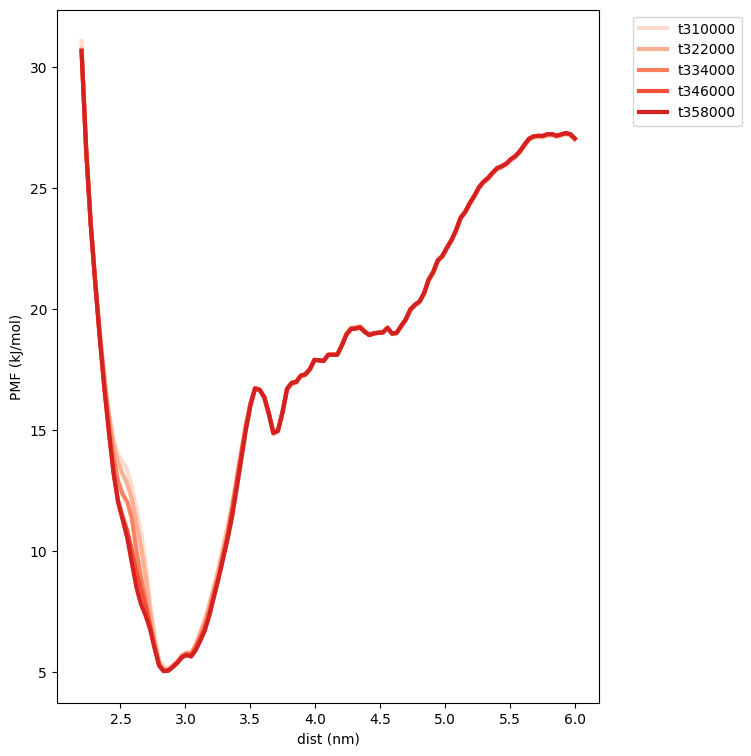

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Reds")
kT = 2.494339
fig, ax = plt.subplots(figsize=(7,9))

for time, awh_pmf in zip(awh_ensemble.awh_results.timeseries[-30::6],
                         awh_ensemble.awh_results.pmf[-30::6]):
    print(time)

    awh_cv1 = awh_pmf.T[0][0]
    awh_cv2 = awh_pmf[0].T[1]
    awh_fes = awh_pmf[:,:,2].T

    # integral over CV2
    awh_fes_int = np.zeros((awh_fes.shape[1]))

    for i in range(awh_fes.shape[1]):
        awh_fes_int[i] = np.trapz(np.exp(-awh_fes[:, i] / kT), awh_cv2)
    awh_fes_int = -np.log(awh_fes_int) * kT


    ax.plot(awh_cv1, awh_fes_int, lw=3, label=time)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_ylabel('PMF (kJ/mol)')
ax.set_xlabel('dist (nm)')
plt.show()

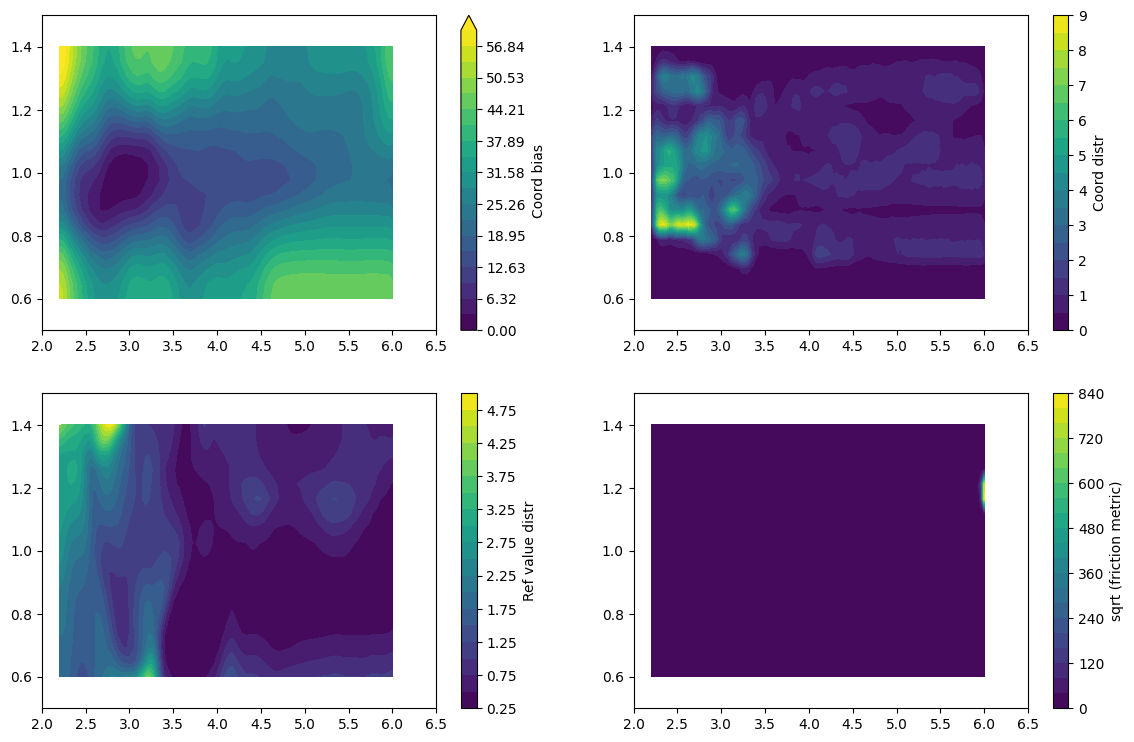

In [9]:
fig, axes = plt.subplots(2,2, figsize=(14,9))
awh_cv1 = awh_pmf.T[0][0]
awh_cv2 = awh_pmf[0].T[1]
awh_fes = awh_pmf[:,:,3].T
levels=np.linspace(0, 60, 20)
mappable = axes[0][0].contourf(
            awh_cv1,
            awh_cv2,
            awh_fes,
            vmax=60,
            levels=levels,
            extend='max',
            alpha=1)
plt.colorbar(mappable, label='Coord bias')

awh_fes = awh_pmf[:,:,4].T
mappable = axes[0][1].contourf(
            awh_cv1,
            awh_cv2,
            awh_fes,
            levels=20,
            alpha=1)
plt.colorbar(mappable, label='Coord distr')

awh_fes = awh_pmf[:,:,5].T
mappable = axes[1][0].contourf(
            awh_cv1,
            awh_cv2,
            awh_fes,
            levels=20,
            alpha=1)
plt.colorbar(mappable, label='Ref value distr')

awh_fes = awh_pmf[:,:,7].T
mappable = axes[1][1].contourf(
            awh_cv1,
            awh_cv2,
            awh_fes,
            levels=20,
            alpha=1)
plt.colorbar(mappable, label='sqrt (friction metric)')

for ax in axes.flatten():
    ax.set_xlim(2, 6.5)
    ax.set_ylim(0.5, 1.5)

# Reweighting

In [312]:
trajectory_list = []
topology_list = []
bonded_topology_list = []

In [313]:
default_raw_load_location = os.getcwd()

for folder in awh_ensemble.rep_folder:
    load_location = f'{default_raw_load_location}/{folder}'

    if not os.path.exists(load_location + '/../start.pdb'):
        raise FileExistsError(load_location + '/../start.pdb')
    trajectory_list.append(load_location +  "/awh.xtc")
    topology_list.append(load_location + '/../start.pdb')
    bonded_topology_list.append(load_location + "/awh.tpr")

In [314]:
u_list = [mda.Universe(topology, trajectory) for topology, trajectory in zip(topology_list, trajectory_list)]

/nethome/yzhuang/git_repo/mdanalysis_dev/package/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [315]:
timeweights_list = []
energyweights_list = []
distances_list = []
cv_list = []

pulling_awh_cvs = ['dim_4', 'dim_5']
awh_pmf = awh_ensemble.awh_results.pmf[-1]
awh_fes = awh_pmf.reshape(-1, 8).T[2]
awh_cvs = awh_pmf.reshape(-1, 8).T[:2]
for u, awh_pullx in zip(u_list, awh_ensemble.awh_pullx):

    trajectory_dt = u.trajectory.dt
    pullx_dt = awh_pullx.data.dim_1[1] - awh_pullx.data.dim_1[0]
    freq_diff = int(trajectory_dt // pullx_dt)

    print(f'Trajectory dt: {trajectory_dt} ps')
    print(f'Pullx dt: {pullx_dt} ps')

    start_frame = int(awh_ensemble.awh_log[0].out_of_initial_stage_time // trajectory_dt)
    end_frame = u.trajectory.n_frames

    start_frame_pullx = start_frame * freq_diff
    end_frame_pullx = end_frame * freq_diff

    # make sure they have the same shape
    if end_frame_pullx > awh_pullx.data.shape[0]:
        end_frame_pullx = awh_pullx.data.shape[0]
        end_frame = end_frame_pullx // freq_diff

    timeweights = np.log(np.arange(0, end_frame-start_frame) + 1)

    pullx_traj = awh_pullx.data[pulling_awh_cvs].values[start_frame_pullx:end_frame_pullx-freq_diff:freq_diff]

    # get the closest index of awh_cvs for each pullx_traj based on squared difference
    g = np.argmin(np.sum((awh_cvs.T[:, np.newaxis, :] - pullx_traj[np.newaxis, :, :])**2, axis=2), axis=0)     
    energyweights = awh_fes[g]

    epj = u.select_atoms('resname EPJ')
    protein_rs = u.select_atoms('resid 108 and resname SER and segid I')

    distances = np.zeros(end_frame-start_frame)
    for i, ts in enumerate(u.trajectory[start_frame:end_frame]):
        distances[i] = mda.analysis.distances.distance_array(
                                                epj.positions,
                                                protein_rs.positions,
                                                box=u.dimensions).min()

    # make sure they have the same shape
    if not len(distances) == len(timeweights) == len(energyweights) == len(pullx_traj):
        print(len(distances), len(timeweights), len(energyweights), len(pullx_traj))
        raise ValueError('Length of distances, timeweights, and energyweights are not the same.')
    
    distances_list.append(distances)
    timeweights_list.append(timeweights)
    energyweights_list.append(energyweights)
    cv_list.append(pullx_traj)

Trajectory dt: 100.0 ps
Pullx dt: 2.0 ps
Trajectory dt: 100.0 ps
Pullx dt: 2.0 ps
Trajectory dt: 100.0 ps
Pullx dt: 2.0 ps
Trajectory dt: 100.0 ps
Pullx dt: 2.0 ps
Trajectory dt: 100.0 ps
Pullx dt: 2.0 ps
Trajectory dt: 100.0 ps
Pullx dt: 2.0 ps
Trajectory dt: 100.0 ps
Pullx dt: 2.0 ps
Trajectory dt: 100.0 ps
Pullx dt: 2.0 ps


In [316]:
distances_concat = np.concatenate(distances_list)
timeweights_concat = np.concatenate(timeweights_list)
energyweights_concat = np.concatenate(energyweights_list)
cv_concat = np.concatenate(cv_list)

In [317]:
# save all the data
np.savez_compressed('awh_data.npz',
                    distances=distances_concat,
                    timeweights=timeweights_concat,
                    energyweights=energyweights_concat,
                    cv=cv_concat)

In [358]:
# load all the data
data = np.load('awh_data.npz')
distances_concat = data['distances']
timeweights_concat = data['timeweights']
energyweights_concat = data['energyweights']
cv_concat = data['cv']

In [359]:
RT = 8.314*10**-3*298 #kJ/mol

normalization_weights = 1.0 - squareform(pdist(cv_concat,"hamming"))
normalization_weights = 1 / np.sum(normalization_weights,-1)

""" Normalize with respect to time.
    For each i,j, sum over """
already_seen=[]
values = 100 * cv_concat.T[0] + cv_concat.T[1]

for i in range(len(cv_concat)):
    if values[i] not in already_seen:
        inds = (values[i] == values)
        timeweights_concat[inds] /= np.sum(inds.astype(float))
        already_seen.append(values[i])

"""Retrieve total weights for each frame"""

time_weights = np.zeros((len(normalization_weights)))
time_weights = normalization_weights * np.exp(- energyweights_concat / RT) * timeweights_concat

In [360]:
def calculate_probabilities(X,labels,time_weights,nclust):
    mu, stds, ws = np.zeros(nclust), np.zeros(nclust), np.zeros(nclust)
    for i in range(nclust):
        weights = time_weights[labels == i]
        samples = X[labels == i]
        mu[i] = np.sum(weights * samples) / np.sum(weights)
        stds[i] = np.sqrt(np.sum(weights * (samples-mu[i])**2) / np.sum(weights))
        ws[i] =  np.sum(weights)
    return mu, stds, ws / ws.sum()

In [361]:
nclust = 50
X = distances_concat.reshape(-1, 1)
clf = KMeans(n_clusters=nclust).fit(X,
                                    time_weights)

In [362]:
mu, stds, weights = calculate_probabilities(X, clf.labels_, time_weights, nclust)
model_parameters = []

In [363]:
for i in range(nclust):
    model_parameters.append(Normal(means=[mu[i]], covs=[stds[i]], covariance_type='diag'))
model = GeneralMixtureModel(model_parameters, weights)

model.fit(X=X, sample_weight=time_weights)

GeneralMixtureModel(
  (distributions): ModuleList(
    (0-49): 50 x Normal()
  )
)

In [364]:
""" Calculate Free Energy diagram """
xrange = np.max(X) - np.min(X)
xlim = [np.min(X), np.max(X)]
X_samp = np.linspace(xlim[0],xlim[1],1000)[:, np.newaxis]
P_X = model.probability(X_samp)

In [365]:
P_X = P_X.numpy()
dG = RT * -np.log(P_X/np.max(P_X))

<Axes: ylabel='Density'>

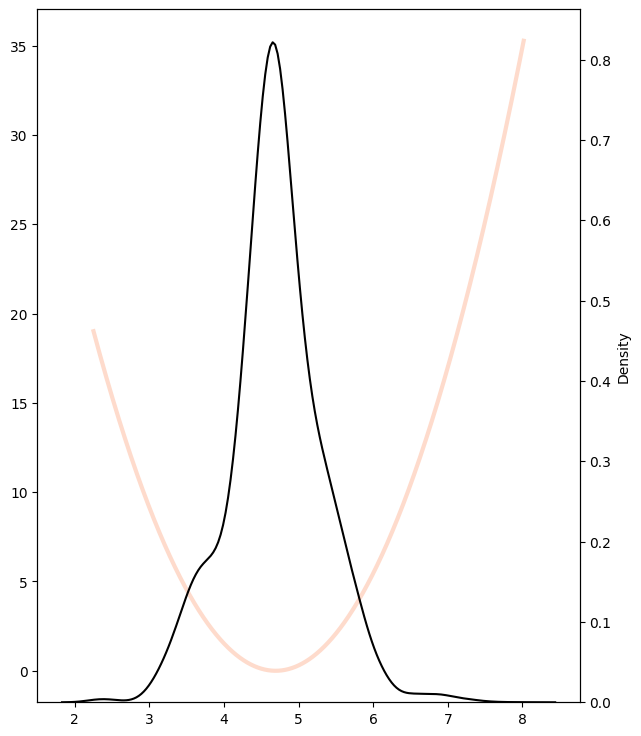

In [366]:
fig, ax = plt.subplots(figsize=(7,9))
ax.plot(X_samp, dG, lw=3)

ax_2 = ax.twinx()
sns.kdeplot(x=X.flatten(),
            weights=time_weights,
            ax=ax_2,
            levels=20,
            thresh=0.005,
            color='k',
            )

In [367]:
def calculate_probabilities_2d(X,labels,time_weights,nclust):
    mu, stds, ws = np.zeros([nclust, 2]), np.zeros([nclust, 2]), np.zeros(nclust)
    for i in range(nclust):
        weights = time_weights[labels == i][:, np.newaxis]
        samples = X[labels == i]
        mu[i] = np.sum(weights * samples, axis=0) / np.sum(weights)
        stds[i] = np.sqrt(np.sum(weights * (samples-mu[i])**2) / np.sum(weights))
        ws[i] =  np.sum(weights)
    return mu, stds, ws / ws.sum()

In [368]:
nclust = 50
X = cv_concat

# standardize the data
X_standard = (X - X.mean(axis=0)) / X.std(axis=0)


clf = KMeans(n_clusters=nclust).fit(X_standard,
                                    time_weights)

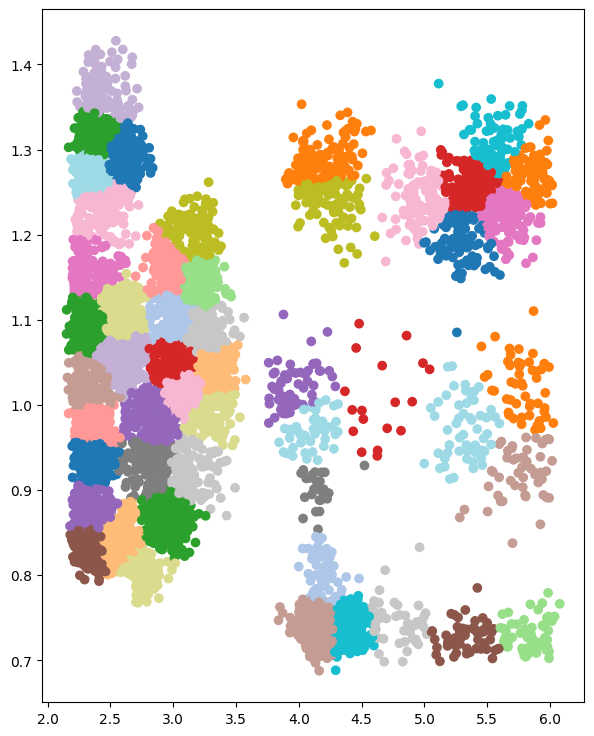

In [369]:
fig, ax = plt.subplots(figsize=(7,9))
ax.scatter(X.T[0], X.T[1], c=clf.labels_, cmap='tab20')

In [370]:
mu, stds, weights = calculate_probabilities_2d(X, clf.labels_, time_weights, nclust)

In [371]:
model_parameters = []
for i in range(nclust):
    model_parameters.append(Normal(means=mu[i], covs=stds[i], covariance_type='diag'))
model = GeneralMixtureModel(model_parameters, weights)

model.fit(X=X[time_weights != 0],
          sample_weight=time_weights[time_weights != 0])

GeneralMixtureModel(
  (distributions): ModuleList(
    (0-49): 50 x Normal()
  )
)

In [372]:
""" Calculate Free Energy diagram """
CV1_minmax = [cv_concat.T[0].min(), cv_concat.T[0].max()]
CV2_minmax = [cv_concat.T[1].min(), cv_concat.T[1].max()]
X_grid, Y_grid = np.meshgrid(np.linspace(CV1_minmax[0], CV1_minmax[1], 1000),
                            np.linspace(CV2_minmax[0], CV2_minmax[1], 1000))
X_samp = np.vstack([X_grid.flatten(), Y_grid.flatten()]).T

P_X = model.probability(X_samp)

In [373]:
P_X = P_X.numpy()
dG = RT * -np.log(P_X/np.max(P_X))

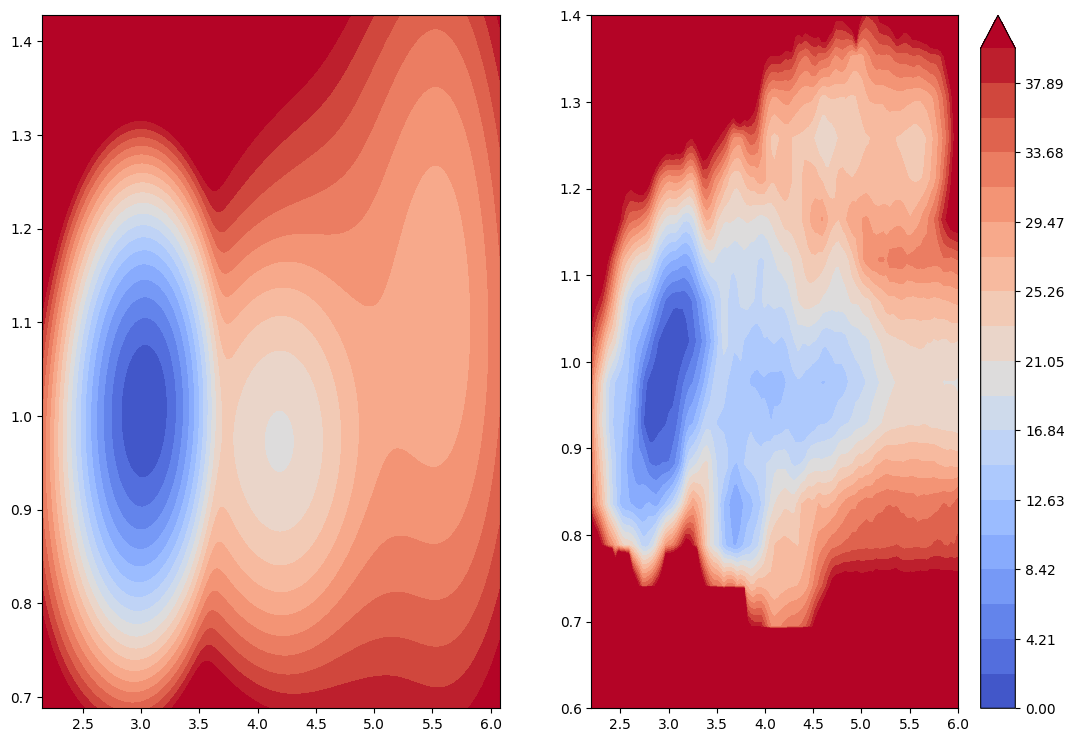

In [374]:
# plot 2d free energy
fig, axes = plt.subplots(1,2,figsize=(13,9))
levels=np.linspace(0, 40, 20)

mappable = axes[0].contourf(
            X_grid,
            Y_grid,
            dG.reshape(X_grid.shape),
            vmax=40,
            levels=levels,
            extend='max',
            cmap='coolwarm')

awh_cv1 = awh_pmf.T[0][0]
awh_cv2 = awh_pmf[0].T[1]
awh_fes = awh_pmf[:,:,2].T
mappable = axes[1].contourf(
            awh_cv1,
            awh_cv2,
            awh_fes,
            vmax=40,
            levels=levels,
            extend='max',
            cmap='coolwarm')
plt.colorbar(mappable)

<Axes: >

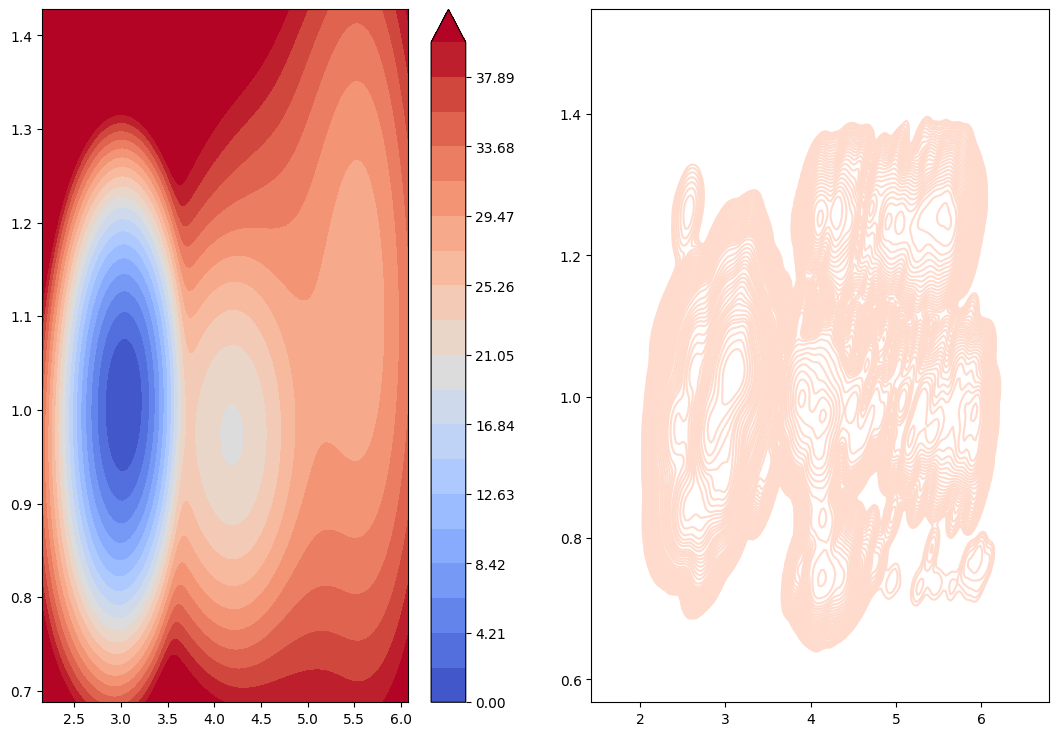

In [386]:
# plot 2d free energy
fig, axes = plt.subplots(1,2,figsize=(13,9))
levels=np.linspace(0, 40, 20)

mappable = axes[0].contourf(
            X_grid,
            Y_grid,
            dG.reshape(X_grid.shape),
            vmax=40,
            levels=levels,
            extend='max',
            cmap='coolwarm')
plt.colorbar(mappable)

levels = np.logspace(-8, 0, 50)
sns.kdeplot(
            cv_concat.T[0],
            cv_concat.T[1],
            weights=time_weights,
            ax=axes[1],
            levels=levels,
)